In [1]:
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import json
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Concatenate, Lambda 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.models import Model
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
# # import tensorflow as tf
print(tf.__version__)
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

2025-05-16 08:02:08.453508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747382528.640025      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747382528.698348      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-d6lcov_b
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-d6lcov_b
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440330 sha256=728ec623b37ed9e38d10b2a105b146f6b650a0c772d338bfc71967492ec26aea
  Stored in directory: /tmp/pip-ephem-wheel-cache-4czpxnix/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf


In [2]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    """
    Đọc và xử lý dữ liệu từ ISIC 2017 dataset
    
    Args:
        image_path: Đường dẫn đến thư mục chứa ảnh gốc
        mask_path: Đường dẫn đến thư mục chứa mask
        binary_path: Đường dẫn đến thư mục chứa mask nhị phân
        csv_file: Đường dẫn đầy đủ đến file CSV chứa nhãn
        label_name: Tên cột chứa nhãn trong file CSV
        img_size: Kích thước ảnh đầu ra (width, height)
        
    Returns:
        images: Numpy array chứa các ảnh đã xử lý
        masks: Numpy array chứa các mask đã xử lý
        binary_masks: Dict chứa mask nhị phân của từng ảnh đã xử lý
        image_ids: List các ID của ảnh
        labels: List các nhãn tương ứng với ảnh
    """

    # Lấy danh sách các file ảnh
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))

    # Khởi tạo lists để lưu dữ liệu
    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []
    
    # Đọc file CSV
    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")
    
    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):
        # Lấy image ID
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        # Kiểm tra file mask có tồn tại
        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue
            
        try:
            

            # Đọc ảnh gốc
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB
            
            
            # Đọc mask
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            
            # Resize ảnh và mask
            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)
            
            # Normalize
            img = img / 255.0
            mask = mask / 255.0
            
            # Đọc mask nhị phân
            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            # Lấy nhãn tương ứng
            label = mel_label[index]
            
            # Thêm vào lists
            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))
            
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue
    
    # Chuyển sang numpy arrays
    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  # Thêm channel dimension cho masks
    labels = np.array(labels)
    
    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")
    
    return images, masks, binary_masks, image_ids, labels

In [3]:
# Đọc tập training
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Train_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_2',
    csv_file='/kaggle/input/read-907/Train_GroundTruth_3.csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 635/635 [02:12<00:00,  4.78it/s]



Đã đọc thành công 635 ảnh
Shape của images: (635, 256, 256, 3)
Shape của masks: (635, 256, 256, 1)
Shape của labels: (635,)


In [4]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Test_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_2',
    csv_file='/kaggle/input/read-907/Test_GroundTruth_3.csv',
     # label_name="melanoma",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 272/272 [00:53<00:00,  5.11it/s]


Đã đọc thành công 272 ảnh
Shape của images: (272, 256, 256, 3)
Shape của masks: (272, 256, 256, 1)
Shape của labels: (272,)


In [5]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [6]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    """Tính Dice hoặc Jaccard coefficient/loss cho TensorFlow hoặc NumPy."""
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)
    
    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")
    
    return score if 'coefficient' in metric else 1 - score

# Hàm TensorFlow
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

# Hàm NumPy
def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [7]:
def CustomSegUNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = tf.keras.layers.ReLU()(c1)
    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = tf.keras.layers.ReLU()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = tf.keras.layers.ReLU()(c2)
    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = tf.keras.layers.ReLU()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = tf.keras.layers.ReLU()(c3)
    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = tf.keras.layers.ReLU()(c3)
    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = tf.keras.layers.ReLU()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = tf.keras.layers.ReLU()(c4)
    c4 = Conv2D(512, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = tf.keras.layers.ReLU()(c4)
    c4 = Conv2D(512, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = tf.keras.layers.ReLU()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(512, (3, 3), padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = tf.keras.layers.ReLU()(c5)
    c5 = Conv2D(512, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = tf.keras.layers.ReLU()(c5)
    c5 = Conv2D(512, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = tf.keras.layers.ReLU()(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    # bottleneck 
    c6 = Conv2D(1024, (3, 3), padding='same')(p5)
    c6 = BatchNormalization()(c6)
    c6 = tf.keras.layers.ReLU()(c6)
    c6 = Conv2D(1024, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = tf.keras.layers.ReLU()(c6)
    c6 = Conv2D(1024, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = tf.keras.layers.ReLU()(c6)

    # Decoder
    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c5])
    c7 = Conv2D(512, (3, 3), padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = tf.keras.layers.ReLU()(c7)
    c7 = Conv2D(512, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = tf.keras.layers.ReLU()(c7)
    c7 = Conv2D(512, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = tf.keras.layers.ReLU()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c4])
    c8 = Conv2D(512, (3, 3), padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = tf.keras.layers.ReLU()(c8)
    c8 = Conv2D(512, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = tf.keras.layers.ReLU()(c8)
    c8 = Conv2D(256, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = tf.keras.layers.ReLU()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c3])
    c9 = Conv2D(256, (3, 3), padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = tf.keras.layers.ReLU()(c9)
    c9 = Conv2D(256, (3, 3), padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = tf.keras.layers.ReLU()(c9)
    c9 = Conv2D(128, (3, 3), padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = tf.keras.layers.ReLU()(c9)

    u10 = UpSampling2D((2, 2))(c9)
    u10 = Concatenate()([u10, c2])
    c10 = Conv2D(128, (3, 3), padding='same')(u10)
    c10 = BatchNormalization()(c10)
    c10 = tf.keras.layers.ReLU()(c10)
    c10 = Conv2D(64, (3, 3), padding='same')(c10)
    c10 = BatchNormalization()(c10)
    c10 = tf.keras.layers.ReLU()(c10)

    u11 = UpSampling2D((2, 2))(c10)
    u11 = Concatenate()([u11, c1])
    c11 = Conv2D(64, (3, 3), padding='same')(u11)
    c11 = BatchNormalization()(c11)
    c11 = tf.keras.layers.ReLU()(c11)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)

    return Model(inputs=inputs, outputs=outputs)
    
# Khởi tạo và kiểm tra mô hình
if __name__ == "__main__":
    model = CustomSegUNet()
    model.summary()

I0000 00:00:1747382775.374471      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 60,918,145 (232.38 MB)

 Trainable params: 60,896,129 (232.30 MB)

 Non-trainable params: 22,016 (86.00 KB)

In [8]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose        
        self.wait = 0
        self.best_accuracy = -float('inf')  # Khởi tạo giá trị accuracy tốt nhất là âm vô cực
        self.consecutive_stops = 0  # Đếm số lần dừng liên tiếp

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [9]:
def convert_to_gray_clahe(images):    
    grays = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # tạo đối tượng CLAHE
    
    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)  
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # chuyển sang ảnh xám

        img_clahe = clahe.apply(gray)  # áp dụng CLAHE
        grays.append(img_clahe)

    
    return np.array(grays)

# Gọi hàm
train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)


In [10]:
print("Train images shape:", train_images_gray_clahe.shape)
print("Train masks shape:", train_masks.shape)

Train images shape: (635, 256, 256)
Train masks shape: (635, 256, 256, 1)


In [11]:
# Tạo và biên dịch mô hình
segunet = CustomSegUNet(input_size=(256, 256, 1))
segunet.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)

# Thiết lập thư mục lưu mô hình
model_checkpoint_dir = 'model'
os.makedirs(model_checkpoint_dir, exist_ok=True)

# Callback theo dõi train accuracy thay vì validation loss/accuracy
early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=3,
    verbose=1
)

# --- Tính thời gian huấn luyện ---
start_time = time.time()

# Huấn luyện mô hình
history = segunet.fit(
    train_images_gray_clahe, train_masks,
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping]
)

end_time = time.time()
training_time = end_time - start_time

# --- Tính trung bình Accuracy và Jaccard ---
avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])

# --- In kết quả ---
print("SegUNet output shape:", segunet.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")


Epoch 1/10


I0000 00:00:1747382804.176443     180 service.cc:148] XLA service 0x7c00b0016f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747382804.177201     180 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747382806.550433     180 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-16 08:07:15.020550: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=3,k3=0} for conv (f32[32,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-16 08:07:15.021893: E 

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.7091 - jaccard_coefficient: 0.3425 - loss: 0.4974

E0000 00:00:1747382895.749696     179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747382895.989608     179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747382897.209762     179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747382897.473516     179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747382905.588020     179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

20/20 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.7140 - jaccard_coefficient: 0.3487 - loss: 0.4908
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 710ms/step - accuracy: 0.8259 - jaccard_coefficient: 0.4950 - loss: 0.3403
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 713ms/step - accuracy: 0.8554 - jaccard_coefficient: 0.5413 - loss: 0.2992
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 712ms/step - accuracy: 0.8710 - jaccard_coefficient: 0.5876 - loss: 0.2610
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 711ms/step - accuracy: 0.8823 - jaccard_coefficient: 0.5958 - loss: 0.2545
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 711ms/step - accuracy: 0.8608 - jaccard_coefficient: 0.5743 - loss: 0.2715
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 711ms/step - accuracy: 0.8978 - jaccard_coefficient: 0.6371 - loss: 0.2223
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 711ms/step - accuracy: 0.9016 - jaccard_coefficient: 0.6574 - loss: 0.2074
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 711ms/step - accuracy: 0.9042 - jac

In [12]:
# Trích xuất dữ liệu từ lịch sử huấn luyện
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)

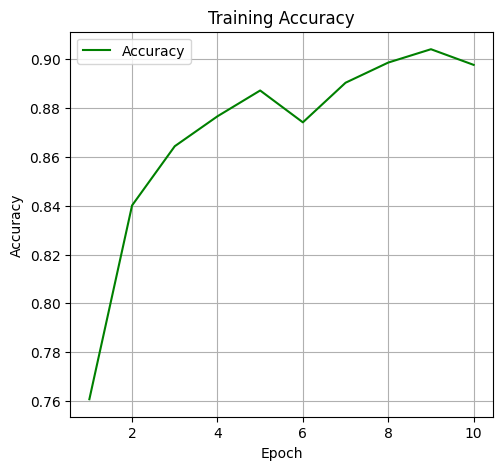

In [13]:
# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

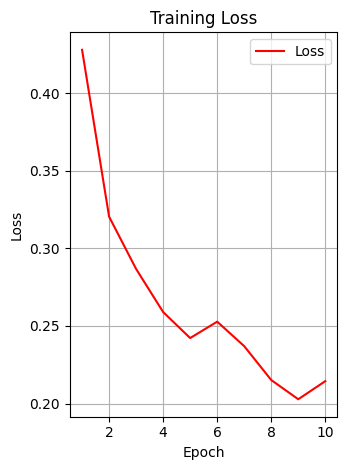

In [14]:
# Vẽ biểu đồ Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
def apply_crf(original_image, model_output):
    """Áp dụng CRF để tinh chỉnh phân đoạn."""
    H, W = original_image.shape[:2]
    model_output = np.squeeze(model_output)
    probs = np.stack([1.0 - model_output, model_output], axis=0)
    
    d = dcrf.DenseCRF2D(W, H, 2)
    d.setUnaryEnergy(unary_from_softmax(probs))
    d.addPairwiseGaussian(sxy=3, compat=3)
    
    if len(original_image.shape) == 2:
        original_image = original_image[..., np.newaxis]
    if original_image.shape[-1] == 3:
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)[..., np.newaxis]
    
    pairwise_energy = create_pairwise_bilateral(sdims=(80, 80), schan=(13,), img=original_image.astype(np.uint8), chdim=2)
    d.addPairwiseEnergy(pairwise_energy, compat=10)
    
    Q = d.inference(10)
    return np.argmax(Q, axis=0).reshape((H, W))

In [16]:
# Đánh giá mô hình
print("Đánh giá trước CRF...")
results = segunet.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Trước CRF - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

# Áp dụng CRF và đánh giá
print("\nĐánh giá sau CRF...")
predictions = segunet.predict(test_images_gray_clahe)
refined_predictions = []

for i in range(len(test_images_gray_clahe)):
    img = test_images_gray_clahe[i]
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    refined_pred = apply_crf(img, predictions[i])
    refined_predictions.append(refined_pred)
    if i < 3:
        cv2.imwrite(f'before_crf_{i}.png', (predictions[i] > 0.5).astype(np.uint8).squeeze() * 255)
        cv2.imwrite(f'after_crf_{i}.png', refined_pred * 255)

refined_predictions = np.array(refined_predictions)
accuracy_after = np_accuracy(test_masks, refined_predictions)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions)
loss_after = np_dice_loss(test_masks, refined_predictions)

print(f"Sau CRF - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

Đánh giá trước CRF...
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5275 - jaccard_coefficient: 0.3304 - loss: 0.5128 
Trước CRF - Dice Loss: 0.5267, Accuracy: 54.08%, Jaccard: 31.94%

Đánh giá sau CRF...
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 535ms/step


[ WARN:0@579.081] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


Sau CRF - Dice Loss: 0.5276, Accuracy: 52.83%, Jaccard: 30.92%
